In [1]:
from mpl_toolkits.mplot3d import Axes3D
import math as m
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import time

from imageio import imread
from matplotlib import cm
import seaborn as sns

In [52]:
## import SRTM  and reading it
srtm = imread('n37_w105_1arc_v3.tif')
#downsample to a quadrant of the total data
srtm = srtm[:100,:100]

10000

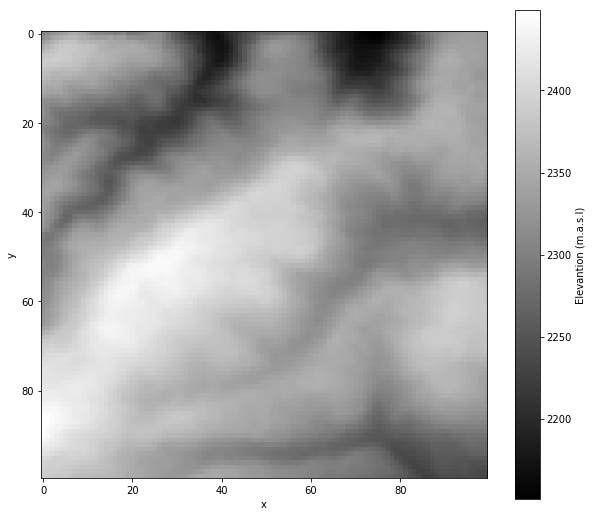

In [51]:
#plotting the dataset to use for this interpolation
plt.figure(figsize=(10,9))
plt.imshow(srtm, cmap = 'gray', interpolation='none')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Elevantion (m.a.s.l)')
plt.savefig('srtm.png')

In [6]:
# ------------ X matrix construction function
def var_matrix(x_points, y_points, deg):
    #reacomodating the shape of the input into a 1D array
    x_points = x_points.reshape(x_points.shape[0]*x_points.shape[1],1)
    y_points = y_points.reshape(y_points.shape[0]*y_points.shape[1],1)
    
    
    #Not necessary but just in case, here is the formula
    pos = m.factorial(deg+2)/(m.factorial(deg)*m.factorial(2))
    #creation of return matrix with first column of intercepts
    X = np.zeros((len(x_points),1))
    X[:,0] = 1.0
    
    #In these loop,s the pos variable is impli(thatcitly named here
    for i in range(1,deg+1):
        for j in range(i+1):
        
            #Stacking polinomial terms in the columns of the X matrix
            X = np.hstack((X, ((x_points**(j)) * (y_points**(i-j)))))
    
    return X




# ----------- functions for error
#R2
def R2(z_data,z_model):
    return 1- np.sum((z_data - z_model)**2.0) / np.sum((z_data - np.mean(z_data))**2.0)

#Mean Square Error
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum(((z_data-z_model)**2.0)) / n

#Bias confidence interval
def conf_int(inv_X, conf):
    men = np.mean(inv_X.diagonal())
    s = np.sqrt(np.sum((inv_X.diagonal() - men)**2))
    return np.asarray([men-conf*s, men+conf*s])

In [7]:
#Reestructuring the data
x = list(np.arange(0,1,1.0/srtm.shape[0]))
y = list(np.arange(0,1,1.0/srtm.shape[1]))
X, Y = np.meshgrid(x, y)

Z = srtm.reshape(len(x)*len(y))

NameError: name 'i_degree' is not defined

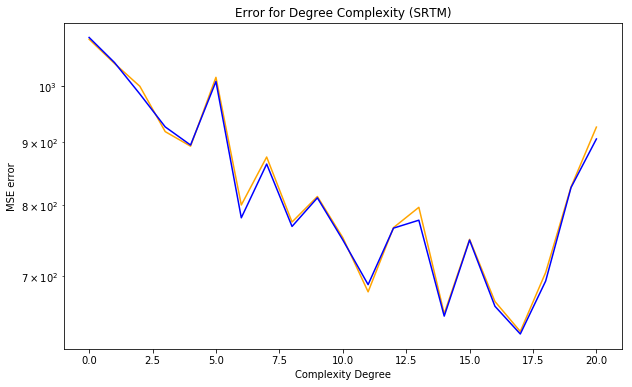

In [36]:
#clock just so check how much time does it take to compute
start_time = time.time()
#lists to save the errors
er_R2 =  []
er_MSE = []

tr_R2 =  []
tr_MSE = []
#variable that determines the maximum polinomial degree to test
i_deg = 15
degree = 35

for k in range(i_deg, degree+1):
    #designing the X matrix and train test split
    Xm = var_matrix(X,Y,k)
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, Z, test_size=0.2)
    #Scikit learn linear regression
    reg = LinearRegression().fit(X_train, Z_train)
    #train and test predicitons
    Ztr_model = reg.predict(X_train)
    Z_model = reg.predict(X_test)
    #appending the errors for further plots
    tr_MSE.append(MSE(Z_train, Ztr_model))
    er_MSE.append(MSE(Z_test,Z_model))
  
#plot    
plt.figure(figsize=(10,6))
plt.plot(range(degree-15+1),er_MSE, label='test', color='orange')
plt.plot(range(degree-15+1),tr_MSE, label = 'train', color='blue')
plt.yscale('log')
plt.ylabel('MSE error')
plt.xlabel('Complexity Degree')
plt.title('Error for Degree Complexity (SRTM)')
plt.xticks(np.arange(0,degree+1-i_deg), np.arange(i_deg, degree+1))
plt.legend()
plt.show()
plt.savefig('OLS_srtm.png')

elapsed_time = time.time() - start_time
print('sec:', elapsed_time, 'hr:', elapsed_time/3600)

(11, 11)
sec: 52.13386154174805 hr: 0.014481628206041125


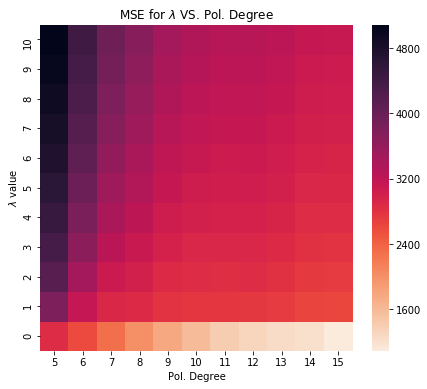

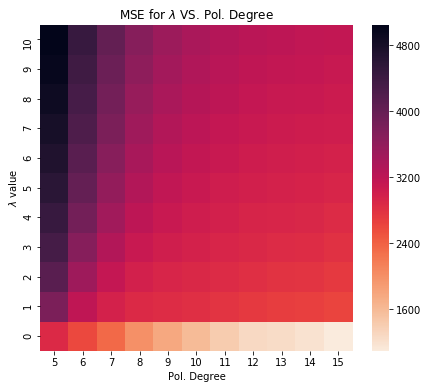

In [28]:
#Ridge Regression
#Error values list
#clock for timing the computation time
start_time = time.time()
#maximum variables to reach
nlambda = 10
#defining a range of complexity degree (initial and final)
i_deg = 5
degree = 15

#Matrixes for error varying lambda and degree (for plotting intensity maps)
mtr_MSE = np.zeros((degree-i_deg+1, nlambda+1))
mer_MSE = np.zeros((degree-i_deg+1, nlambda+1))
#mtr_R2 = np.zeros((degree-i_deg+1, nlambda+1))
#mer_R2 = np.zeros((degree-i_deg+1, nlambda+1))
print(mtr_MSE.shape)

for deg in range(i_deg, degree+1):
    
    #degisning the X matrix and train test splitting
    Xm = var_matrix(X,Y,deg)
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, Z, test_size=0.2)
    
    
    for l in range(nlambda+1):
        
        #Ridge regression through Scikit Learn
        reg = Ridge(alpha=l).fit(X_train, Z_train)
        beta = reg.coef_
        #mtrain and test predictions
        Z_model = reg.predict(X_test)
        Ztr_model = reg.predict(X_train)

        #Adding to the matrix the errors for further heatmap plot
        #mtr_R2[deg,l] = R2(Z_train, Ztr_model)
        mtr_MSE[deg-i_deg,l] = MSE(Z_train, Ztr_model)
        #mer_R2[deg,l] = R2(Z_test,Z_model)
        mer_MSE[deg-i_deg,l] = MSE(Z_test,Z_model)

#figure size parameters
largo, alto = 7, 6
#plot test set
plt.figure(figsize=(largo, alto))
ax = sns.heatmap(mer_MSE.T, annot=False, cmap='rocket_r', vmin=mer_MSE.min(), vmax=mer_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
ax.set_xticklabels(np.arange(i_deg, degree+1))
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('srtm_ridge_test.png')

#plot train set
plt.figure(figsize=(largo, alto))
ax = sns.heatmap(mtr_MSE.T, annot=False, cmap='rocket_r', vmin=mtr_MSE.min(), vmax=mtr_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
ax.set_xticklabels(np.arange(i_deg, degree+1))
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('srtm_ridge_train.png')

elapsed_time = time.time() - start_time
print('sec:', elapsed_time, 'hr:', elapsed_time/3600)

/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/uio/modules/packages/python/Anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


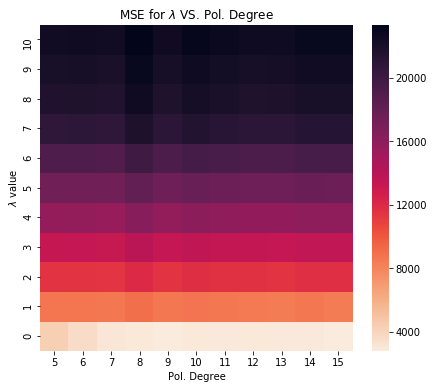

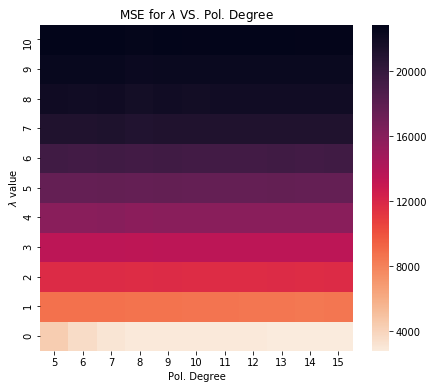

In [29]:
#Lasso Regression
#Error values list
#maximum variables to reach
nlambda = 10
#defining a range of complexity degree (initial and final)
i_deg = 5
degree = 15

#Matrixes for error varying lambda and degree (for plotting intensity maps)
mtr_MSE = np.zeros((degree-i_deg+1, nlambda+1))
mer_MSE = np.zeros((degree-i_deg+1, nlambda+1))
#mtr_R2 = np.zeros((degree-i_deg+1, nlambda+1))
#mer_R2 = np.zeros((degree-i_deg+1, nlambda+1))

for deg in range(i_deg, degree+1):
    #Designing the X matrix
    Xm = var_matrix(X,Y,deg)
    X_train, X_test, Z_train, Z_test = train_test_split(Xm, Z, test_size=0.2)
    

    for l in range(nlambda+1):
        #Lasso regresion through Scikit Learn
        reg = Lasso(alpha=l).fit(X_train, Z_train)
        beta = reg.coef_
        #train and test predictions
        Z_model = reg.predict(X_test)
        Ztr_model = reg.predict(X_train)
        #adding errors to the matrix for further heatmat plotting
        #mtr_R2[deg-i_deg,l] = R2(Z_train, Ztr_model)
        mtr_MSE[deg-i_deg,l] = MSE(Z_train, Ztr_model)
        #mer_R2[deg,l] = R2(Z_test,Z_model)
        mer_MSE[deg-i_deg,l] = MSE(Z_test,Z_model)

#figure size parameters
largo, alto = 7, 6
#plot test set
plt.figure(figsize=(largo, alto))
ax = sns.heatmap(mer_MSE.T, annot=False, cmap='rocket_r', vmin=mer_MSE.min(), vmax=mer_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
ax.set_xticklabels(np.arange(i_deg, degree+1))
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('srtm_lasso_test.png')

#plot train set
plt.figure(figsize=(largo, alto))
ax = sns.heatmap(mtr_MSE.T, annot=False, cmap='rocket_r', vmin=mtr_MSE.min(), vmax=mtr_MSE.max())
plt.gca().invert_yaxis()
#plt.imshow(mer_MSE, cmap='YlGnBu', interpolation='nearest')
plt.ylabel('$\lambda$ value')
plt.xlabel('Pol. Degree')
ax.set_xticklabels(np.arange(i_deg, degree+1))
plt.title('MSE for $\lambda$ VS. Pol. Degree')
plt.savefig('srtm_lasso_train.png')